# Métodos de agrupamiento para Bioinformática

Emplea las APIs scikit-learn, scikit-bio y sus dependencias

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import itertools
import collections
import random

Populating the interactive namespace from numpy and matplotlib


El objetivo es explorar la nivel de especies de unas cuantas especies microbianas basados en los datos de secuencia.
El resultado será determinar si las muestras (secuencias) de las misma especie son similares

Se cargarán 5 secuencias anotadas de cada especie la base de datos 16S rRNA desde la base de datos de Greengenes

La salida es seq_data que contiene la etiquetas de clase y el tamaño de clases, a través del siguiente método (load_annotated_sequences)

In [2]:
import collections
import qiime_default_reference as qdr
import skbio

def load_annotated_sequences(taxa_of_interest, class_size=None, sequence_length=500, 
                             verbose=True, ids_to_exclude=None):
    
    # Load the taxonomic data
    result = {}
    SequenceRecord = collections.namedtuple(typename='SequenceRecord',
                                            field_names=['identifier', 'split_taxonomy', 'taxonomy', 'sequence'])
    
    taxon_to_sequence_records = {t: list() for t in taxa_of_interest}        
    
    id_to_taxonomy_record = {}
    for line in open(qdr.get_reference_taxonomy()):
        identifier, taxonomy = line.strip().split('\t')
        id_to_taxonomy_record[identifier] = taxonomy
    
    for seq in skbio.io.read(qdr.get_reference_sequences(), format='fasta', 
                             constructor=skbio.DNA):
        identifier = seq.metadata['id']
        if ids_to_exclude is not None and identifier in ids_to_exclude:
            # if this id was tagged to not be included in the result, 
            # move on to the next record
            continue
        
        tax = id_to_taxonomy_record[identifier]
        split_taxonomy = [e.strip() for e in tax.split(';')]
        taxonomy = ';'.join(split_taxonomy)
        if taxonomy not in taxon_to_sequence_records:
            # if this is not one of the taxa that we're interested in, 
            # move on to the next record. 
            continue
        
        if seq.has_degenerates():
            # for the purpose of this exercise we'll skip records 
            # that have non-ACGT characters. if degenerate characters
            # are present, move on to the next record
            continue
            
        if sequence_length is not None:
            sequence = seq[:sequence_length]
        else:
            sequence = seq

        sr = SequenceRecord(identifier=identifier,
                            split_taxonomy=split_taxonomy,
                            taxonomy=taxonomy,
                            sequence=sequence)
        taxon_to_sequence_records[taxonomy].append(sr)
        
    if verbose:
        for taxon, srs in taxon_to_sequence_records.items():
            print("%d sequences were identified for taxon %s." % (len(srs), taxon))
    
    if class_size is None:
        result = {sr.identifier: sr for srs in taxon_to_sequence_records.values() for sr in srs}
    else:
        result = {}
        for taxon, srs in taxon_to_sequence_records.items():
            if class_size > len(srs):
                raise ValueError("Class size (%d) too large for taxon %s, which has only %d non-degenerate sequences." % 
                                 (class_size, t, len(srs)))
            sampled_sequence_records = random.sample(srs, k=class_size)
            result.update({sr.identifier: sr for sr in sampled_sequence_records})

    return result

Definiendo las taxonomias de interes y el número de muestras por especie se extraen de toda la base de datos

In [3]:
taxa_of_interest = {
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__stercorea',
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri',
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica',
    'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans',
    'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes',
    'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__veronii',
    'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__viridiflava'
}
sequences_per_taxon = 5

seq_data = load_annotated_sequences(taxa_of_interest, class_size=sequences_per_taxon)

17 sequences were identified for taxon k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__viridiflava.
35 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__stercorea.
121 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri.
26 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica.
24 sequences were identified for taxon k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__veronii.
127 sequences were identified for taxon k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes.
15 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Flavoba

Se puede dar un vistazo a las muestras de la siguiente manera

In [4]:
for sr in random.sample(list(seq_data.values()), 3):
    print(sr.identifier)
    print(sr.taxonomy)
    print(sr.sequence)
    print(len(sr.sequence))
    print('🦠')

4321915
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica
TAGAGTTTGAGCTGGGCTCAGGATGAACGCTAGCTACAGGCTTAACCCATTTAAGGCGAGGGGAAACGGCATTAAGTGCTTGCGCTTTTTGGACGTCGACCGGCGCACGGGTGAGTAACGCGTATCCAACCTTCCCACAACTAAGGGATAACCTGCCGAAAGGCAGACTAATACCTTATGTAATCCTTTGATGGCATCAGATAAGGATAAAAGATTTATCGGTTATGGATGGGGATGCGTCTGATTAGCTTGTTGGCGGGGTAACGGCCCACCAAGGCAACGATCAGTAGGGGTTCTGAGAGGAAGGTCCCCCACATTGGAACTGAGACACGGTCCAAACTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGGAAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTATGGGGATAAAGTCAATCACGTGTGATTGTTGGCAGGTACCATACGAATAAGGACC
500
🦠
3156638
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__stercorea
CAGGCTTAACACATGCAAGTCGAGGGGCAGCATGTTGGTTGCTTGCAACCAATGATGGCGACCGGCGCACGGGTGAGTAACGCGTATCCAACCTGCCGTCTACTCTTGGACAGCCTTCTGAAAGGAAGATTAATCCAAGATGGGGTCATGAGTTCACATGTCCGCATGATTAAAGGTATTTTCCAGTAAACGATGGGGATGCGTTCCATTAGATAGTAGGCGGGGTAACGGCCCACCAAGGCAACAATCAGTAGGGTTAC

Ahora hay que definir o seleccionar las caracterisiticas de las secuencias que se proporcionarán al algoritmo
En este caso se emplea una tecnica llamda k-mer 

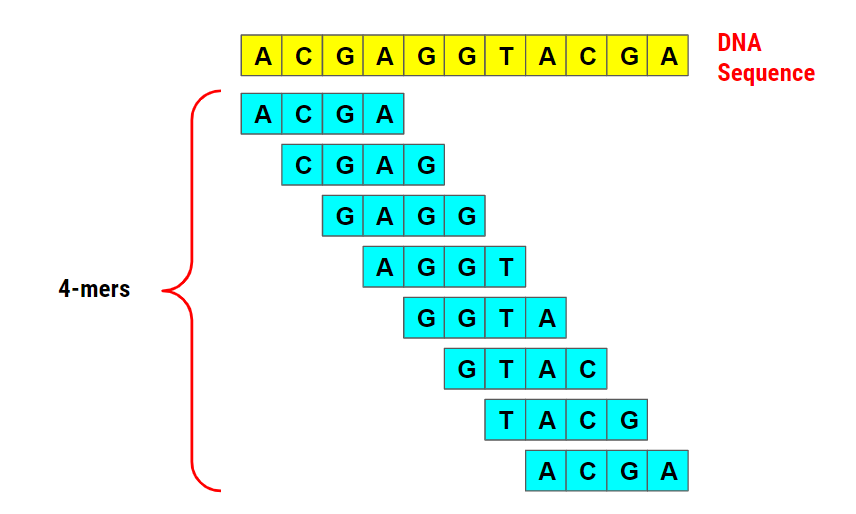

In [5]:
k = 4

In [6]:
def feature_table_from_sequence_records(sequence_records, k):
    kmer_frequencies = {id_ : sr.sequence.kmer_frequencies(k=k) for id_, sr in sequence_records.items()}
    result = pd.DataFrame(kmer_frequencies).fillna(0).astype(int).T
    result.index.name = 'id'
    return result

In [7]:
sequence_feature_table = feature_table_from_sequence_records(seq_data, k)
sequence_feature_table[:7]

,GAGT,AGTT,GTTT,TTTG,TTGA,TGAT,GATC,ATCA,TCAT,CATG,...,AAAT,ACTA,ACCC,CCCC,CCCA,GGTT,AAAA,CCAC,CAAA,TGTC
id,,,,,,,,,,,,,,,,,,,,,
91834,3,3,2,2,3,3,4,3,1,3,...,0,0,0,0,0,0,0,0,0,0
394796,1,1,2,1,1,2,4,3,0,1,...,0,0,0,0,0,0,0,0,0,0
89393,1,2,1,1,2,4,4,2,0,1,...,0,0,0,0,0,0,0,0,0,0
65400,1,2,2,1,2,3,3,2,0,2,...,0,0,0,0,0,0,0,0,0,0
3643491,1,1,1,1,3,2,3,2,0,1,...,0,0,0,0,0,0,0,0,0,0
347138,2,2,1,1,2,1,2,2,1,2,...,2,1,2,1,1,3,1,2,1,0
527574,2,1,1,1,1,3,2,1,1,3,...,1,0,4,0,2,4,0,3,2,2


Las secuencias ya estan etiquetas (curadas) por lo que hechemos un vistazo a como se conformaron.

In [8]:
def feature_labels_from_sequence_records(sequence_records):
    result = pd.DataFrame({id_:sr.split_taxonomy for id_, sr in sequence_records.items()}).T
    result.columns = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    result.index.name = 'id'
    legend_entries = []
    for _, (g, s, p) in result[['genus', 'species', 'phylum']].iterrows():
        legend_entries.append('%s %s (%s)' % (g[3:], s[3:], p[3:]))
    result['legend entry'] = legend_entries
    return result

In [9]:
sequence_labels = feature_labels_from_sequence_records(seq_data)
sequence_labels[1:35:5]

,domain,phylum,class,order,family,genus,species,legend entry
id,,,,,,,,
394796,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__viridiflava,Pseudomonas viridiflava (Proteobacteria)
527574,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__stercorea,Prevotella stercorea (Bacteroidetes)
326482,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__copri,Prevotella copri (Bacteroidetes)
1066621,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__melaninogenica,Prevotella melaninogenica (Bacteroidetes)
275708,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__veronii,Pseudomonas veronii (Proteobacteria)
855538,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Propionibacteriaceae,g__Propionibacterium,s__acnes,Propionibacterium acnes (Actinobacteria)
1058276,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)


Aqui ya se tienen los datos listo para realizar los algoritmos de agrupamiento

# Algoritmo de Kmeans

Algoritmo para agrupación de tipo partición

Observamos el comportamiento de los datos a través de la matríz de distancias

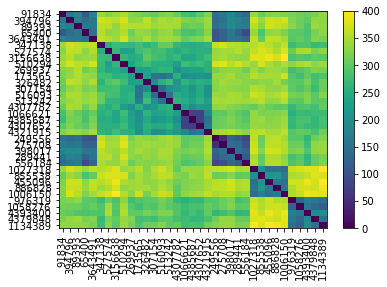

In [10]:
import skbio.diversity

sequence_distance_matrix = skbio.diversity.beta_diversity('manhattan', sequence_feature_table, ids=sequence_feature_table.index)
sequence_distance_matrix

In [11]:
dataKmeans=sequence_feature_table
dataKmeans.describe()

,GAGT,AGTT,GTTT,TTTG,TTGA,TGAT,GATC,ATCA,TCAT,CATG,...,AAAT,ACTA,ACCC,CCCC,CCCA,GGTT,AAAA,CCAC,CAAA,TGTC
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,1.857143,1.485714,0.857143,2.057143,1.800000,2.057143,1.971429,1.571429,0.428571,2.171429,...,0.342857,0.714286,0.600000,1.142857,1.914286,1.542857,0.200000,1.828571,0.657143,0.428571
std,1.166767,0.886879,0.601119,1.349136,0.833137,1.027357,1.200140,0.814779,0.608069,1.248192,...,0.591253,0.667367,0.976187,1.141280,1.615575,1.244821,0.472789,1.688816,0.764771,0.557606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.500000,1.000000,1.000000,1.500000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,0.000000
75%,3.000000,2.000000,1.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,2.000000,3.000000,2.500000,0.000000,3.000000,1.000000,1.000000
max,4.000000,4.000000,2.000000,5.000000,3.000000,4.000000,4.000000,3.000000,2.000000,5.000000,...,2.000000,2.000000,4.000000,4.000000,5.000000,4.000000,2.000000,5.000000,3.000000,2.000000


Los datos estan balanceados, con 5 secuencias para cada una de las 7 clases

In [12]:
sequence_labels['species'].describe()

count                 35
unique                 7
top       s__viridiflava
freq                   5
Name: species, dtype: object

Se crea el entorno para las gráficas y el algoritmo de Kmeans

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

%matplotlib inline 
#notebook
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (9,9)
plt.style.use('ggplot')

Se establecen los vectores de entrada y las clases de salida

Se obtenen 3 componentes por PCA para visualizar de alguna manera como están distribuidos los datos

In [14]:
from sklearn.decomposition import PCA
X=np.array(dataKmeans)
y,Y=np.unique(np.array(sequence_labels['species']),return_inverse=True)
X.shape

(35, 256)

In [15]:
Y

array([6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 5, 5,
       5, 5, 5, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4], dtype=int64)

Se aplica el algoritmo de PCA donde los números de componentes es definido por C

In [16]:
C=12
pca = PCA(n_components=C).fit(X)

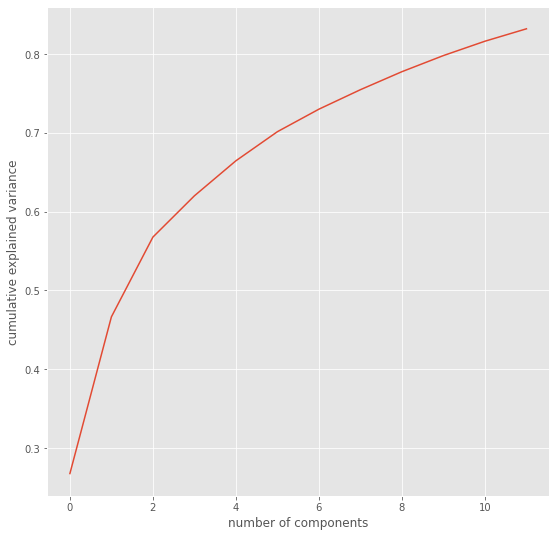

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [18]:
X_pca=PCA(n_components=C).fit_transform(X)

<IPython.core.display.Javascript object>


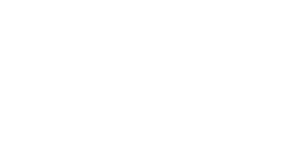

In [19]:
%matplotlib notebook
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ="3d")
 
# Creating plot
colores=['blue','red','green','black','cyan','yellow','orange']
asignar=[]
for row in Y:
    asignar.append(colores[row])
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
plt.title("simple 3D scatter plot with 7 species")
 
# show plot
plt.show()


Empleamos la técnica de gráficar para múltiples grupos de Kmeans y encontrar el codo

In [20]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
kmeansCen = [kmeans[i].fit(X_pca) for i in range(len(kmeans))]
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Ahora veamos una gráfica de los datos agrupados

Donde los 'o' son las clases verdaderas y '*' las clases definidas por Kmeans

<IPython.core.display.Javascript object>


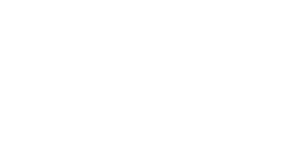

In [21]:
# Predicting the clusters
k_labels = kmeans[6].predict(X_pca)

%matplotlib notebook
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ="3d")
 
# Creating plot
colores=['blue','red','green','blue','cyan','yellow','orange']
predecir=[]
for row in k_labels:
    predecir.append(colores[row])
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], marker='*',c=predecir,s=80)
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], marker='o',c=asignar,s=20)
plt.title("simple 3D scatter plot with 7 species")
 
# show plot
plt.show()

In [22]:
print(Y)
print(k_labels)

[6 6 6 6 6 3 3 3 3 3 1 1 1 1 1 2 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]
[4 4 4 4 4 6 6 3 6 5 3 5 3 3 3 5 0 0 0 0 4 4 4 4 4 1 1 1 1 1 2 2 2 2 2]


In [23]:
np.unique(k_labels,return_inverse=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([4, 4, 4, 4, 4, 6, 6, 3, 6, 5, 3, 5, 3, 3, 3, 5, 0, 0, 0, 0, 4, 4,
        4, 4, 4, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int64))

In [24]:
kMeans=kmeans[6]

Función para guardar el modelo para posterior uso

In [25]:
import pickle
pickle.dump(kMeans, open("kmeans.pkl", 'wb'))

Reetiquetamos los datos para realizar la matriz de confusión y ver que tan bien se realizó el agrupamiento con respecto a las secuencias correctas

In [26]:
# Prep
k_labels_matched = np.empty_like(k_labels)

# For each cluster label...
for p in np.unique(k_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==p)*(Y==t)) for t in np.unique(Y)]
    k_labels_matched[k_labels==p] = np.unique(Y)[np.argmax(match_nums)]

In [27]:
print(Y)
print(k_labels_matched)

[6 6 6 6 6 3 3 3 3 3 1 1 1 1 1 2 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]
[5 5 5 5 5 3 3 1 3 1 1 1 1 1 1 1 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]


In [28]:
confusion_matrix = pd.crosstab(Y, k_labels_matched, rownames=['Verdadero'], colnames=['Kmeans'])
print(confusion_matrix)

Kmeans     0  1  2  3  4  5
Verdadero                  
0          5  0  0  0  0  0
1          0  5  0  0  0  0
2          0  1  4  0  0  0
3          0  2  0  3  0  0
4          0  0  0  0  5  0
5          0  0  0  0  0  5
6          0  0  0  0  0  5


Populating the interactive namespace from numpy and matplotlib


C:\Users\polbo\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<AxesSubplot:xlabel='Kmeans', ylabel='Verdadero'>

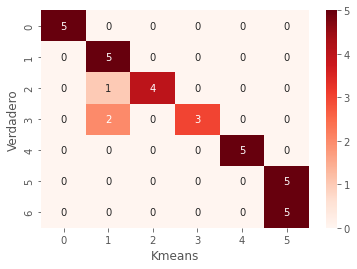

In [29]:
%pylab inline

import seaborn as sb
sb.heatmap(confusion_matrix, annot=True, cmap='Reds')

# Algoritmo por Jerarquia de Aglomeración

Algoritmo de agrupamiento por jerarquia, empleando todas las secuencias de alta dimension

In [30]:
import scipy.cluster.hierarchy as sch

Crear el dendrograma, a través de la distancia EUCLIDEAN, y la distancia entre clusters WARD

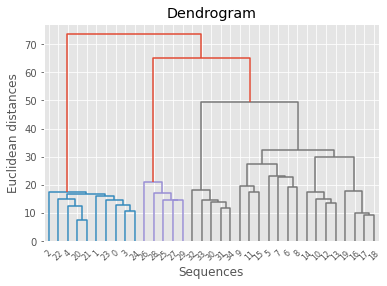

In [31]:
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Sequences')
plt.ylabel('Euclidean distances')
plt.show()

Obtener las etiquetas del dendrograma con H=7 clusters, realizando el etiquetado de todas las secuencias

In [32]:
H=7
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = H, affinity = 'euclidean', linkage ='ward')

In [33]:
h_labels=hc.fit_predict(X)

In [34]:
print(Y)
print(h_labels)

[6 6 6 6 6 3 3 3 3 3 1 1 1 1 1 2 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]
[3 3 3 3 3 0 0 0 0 6 5 6 5 5 5 6 4 4 4 4 3 3 3 3 3 2 2 2 2 2 1 1 1 1 1]


Reetiquetamos los datos para realizar la matriz de confusión y ver que tan bien se realizó el agrupamiento con respecto a las secuencias correctas

In [35]:
# Prep
h_labels_matched = np.empty_like(h_labels)

# For each cluster label...
for p in np.unique(h_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((h_labels==p)*(Y==t)) for t in np.unique(Y)]
    h_labels_matched[h_labels==p] = np.unique(Y)[np.argmax(match_nums)]

In [36]:
print(Y)
print(k_labels_matched)

[6 6 6 6 6 3 3 3 3 3 1 1 1 1 1 2 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]
[5 5 5 5 5 3 3 1 3 1 1 1 1 1 1 1 2 2 2 2 5 5 5 5 5 0 0 0 0 0 4 4 4 4 4]


Heirarchical  0  1  2  3  4  5
Verdadero                     
0             5  0  0  0  0  0
1             0  5  0  0  0  0
2             0  1  4  0  0  0
3             0  2  0  3  0  0
4             0  0  0  0  5  0
5             0  0  0  0  0  5
6             0  0  0  0  0  5
Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:xlabel='Heirarchical', ylabel='Verdadero'>

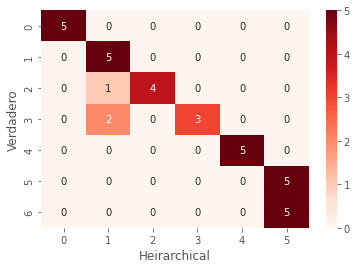

In [37]:
confusion_matrixH = pd.crosstab(Y, k_labels_matched, rownames=['Verdadero'], colnames=['Heirarchical'])
print(confusion_matrixH)

%pylab inline

import seaborn as sb
sb.heatmap(confusion_matrixH, annot=True, cmap='Reds')